# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig, save_fig

# Setup

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load_parameters('calibration')
model.load_data()
model.name = 'baseline'

In [3]:
model_HtM_debt = model.copy()
model_HtM_debt.load_parameters('calibration_HtM_debt')
model_HtM_debt.load_data()
model_HtM_debt.name = 'HtM_debt'

In [4]:
par = model.par
ss = model.ss

In [5]:
varlist = [
    ('u','unemployment rate'),
    ('delta','separation rate'),
    ('lambda_u','job-finding-rate'),
    ('RealR','real interest rate'),
    ('tau','tax rate'),    
    ('qB','value of government debt'),
]

# Solve

In [6]:
models = [model,model_HtM_debt]

In [7]:
for model_ in models:
    
    print(f'### {model_.name}')
    
    model_.par.jump_shock_TFP = 0.0
    model_.find_ss(do_print=True)
    print('')
    model_.compute_jacs(do_print=True)
    
    print('')
    print('')

### baseline
guess:
     R =   0.97668498 -> B-A_hh =   0.65279085
find bracket to search in:
  0: R =   0.97793498 -> B-A_hh =   0.64837231
  1: R =   0.98980998 -> B-A_hh =   0.56287461
  2: R =   0.99574748 -> B-A_hh =   0.40583018
  3: R =   0.99871623 -> B-A_hh =   0.19481615
  4: R =   1.00020060 -> B-A_hh =  -0.01949659
brentq:
  0: R =   1.00006556 -> B-A_hh =   0.00651657
  1: R =   1.00009939 -> B-A_hh =   0.00015924
  2: R =   1.00010023 -> B-A_hh =  -0.00000007
  3: R =   1.00010023 -> B-A_hh =   0.00000000
  4: R =   1.00010023 -> B-A_hh =  -0.00000000

R =   1.00010023

steady state found in 26.3 secs

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for RealR_ex_post   in 1.0 secs
curly_Y and curly_D calculated for delta           in 1.1 secs
curly_Y and curly_D calculated for lambda_u        in 1.1 secs
curly_Y and curly_D calculated for phi_obar        in 1.0 secs
curly_Y and curly_D calculated for shock_be

# Baseline

In [8]:
basepol = 'u_bar'
shock_value = 0.01
scale = 100
rho = 0.90

In [9]:
K = 100
shock_specs = {f'd{basepol}':np.zeros(par.T)}
shock_specs[f'd{basepol}'][:K] += shock_value*rho**np.arange(K)

In [10]:
for model_ in models:
    
    print(f'### {model_.name} ###\n')
        
    model_.find_transition_path(shock_specs=shock_specs,do_print=True)
    
    print('')
    print('')

### baseline ###

finding the transition path:
 it =   0 -> max. abs. error = 1.01e-05
   0.00e+00 in errors_Vj
   2.78e-17 in errors_Vv
   0.00e+00 in errors_Pi
   7.73e-06 in errors_assets
   1.39e-17 in errors_ut
   0.00e+00 in errors_vt
   1.01e-05 in errors_U_UI
 it =   1 -> max. abs. error = 5.57e-08
   4.86e-11 in errors_Vj
   5.57e-08 in errors_Vv
   5.52e-08 in errors_Pi
   2.16e-09 in errors_assets
   6.28e-11 in errors_ut
   3.12e-10 in errors_vt
   9.86e-10 in errors_U_UI
 it =   2 -> max. abs. error = 5.38e-11
   2.58e-14 in errors_Vj
   5.38e-11 in errors_Vv
   3.78e-11 in errors_Pi
   1.06e-12 in errors_assets
   1.08e-13 in errors_ut
   3.03e-13 in errors_vt
   2.78e-13 in errors_U_UI

transition path found in 5.6 secs


### HtM_debt ###

finding the transition path:
 it =   0 -> max. abs. error = 1.01e-05
   0.00e+00 in errors_Vj
   2.78e-17 in errors_Vv
   0.00e+00 in errors_Pi
   4.39e-06 in errors_assets
   1.39e-17 in errors_ut
   0.00e+00 in errors_vt
   1.01e-05 

In [11]:
for model_ in models:
    model_.find_IRFs(shock_specs=shock_specs,do_print=True)

linear transition path found in 0.3 secs [finding solution matrix: 0.2 secs]
linear transition path found in 0.3 secs [finding solution matrix: 0.2 secs]


### baseline ###

### varnames ###


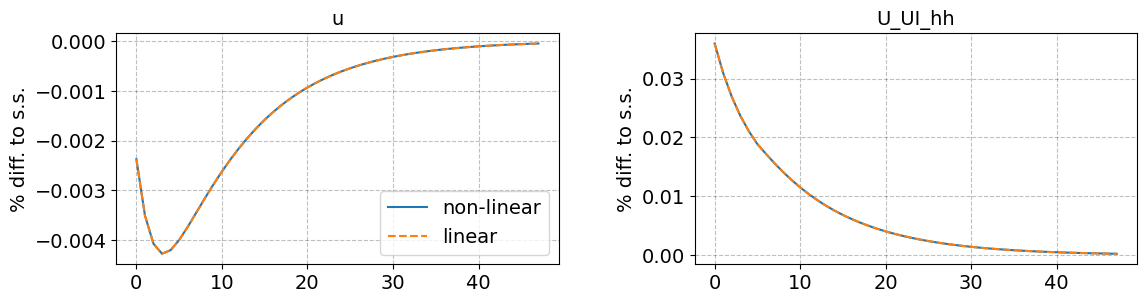


### HtM_debt ###

### varnames ###


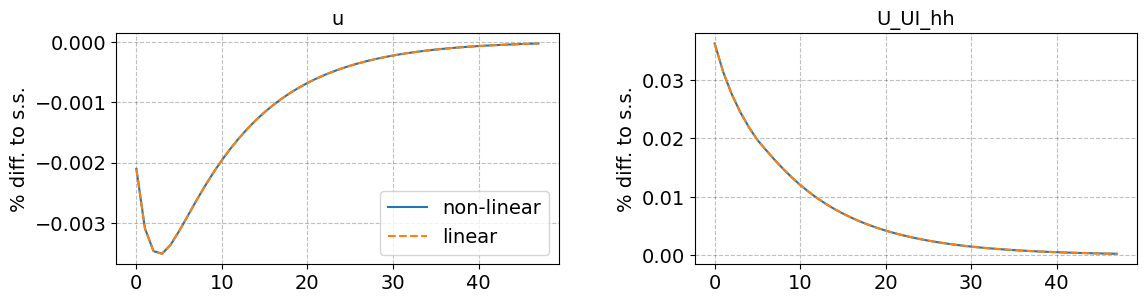

In [12]:
for model_ in models:
    print(f'### {model_.name} ###\n')    
    model_.show_IRFs(['u','U_UI_hh'],do_shocks=False,do_targets=False,do_linear=True,T_max=48)

# Alternative policies

In [13]:
def calc(model,pol):
    
    Z = {}
    U = {}

    for varname,_ in varlist:

        Z[varname] = np.zeros((par.T,len(model.shocks)*par.T))
        for i,shock in enumerate(model.shocks):
            Z[varname][:,i*par.T:(i+1)*par.T] = model.jac[(varname,shock)]

        U[varname] = np.zeros((par.T,len(model.unknowns)*par.T))
        for i,unknown in enumerate(model.unknowns):
            U[varname][:,i*par.T:(i+1)*par.T] = model.jac[(varname,unknown)]

    G_U = -np.linalg.solve(model.H_U,model.H_Z)
    Q = Z['u'] + U['u']@G_U

    d = {}
    for i in range(len(model.shocks)):
        if model.shocks[i] == pol: break
        
    Q_ = Q[:,i*par.T:(i+1)*par.T]
    d['pol'] = dpol = np.linalg.solve(Q_,model.IRF[('u')]) 
    G_U_dpol = G_U[:,i*par.T:(i+1)*par.T]@dpol
    
    d['u'] = U['u']@G_U_dpol
    for varname,_ in varlist:
        d[varname] = U[varname]@G_U_dpol + Z[varname][:,i*par.T:(i+1)*par.T]@dpol 
    
    return d

In [14]:
pols = [
    ('G','public spending','-',1),
    ('public_transfer','public transfer','-',1),
    ('wage_subsidy','wage subsidy','--',1),
    ('hiring_subsidy','hiring subsidy','--',1),
    ('phi_obar','UI level',':',2),
    ]

if not np.isclose(par.phi_obar_ss,par.phi_ubar):
    pols.append(('u_bar','UI duration',':',2))

### baseline ###


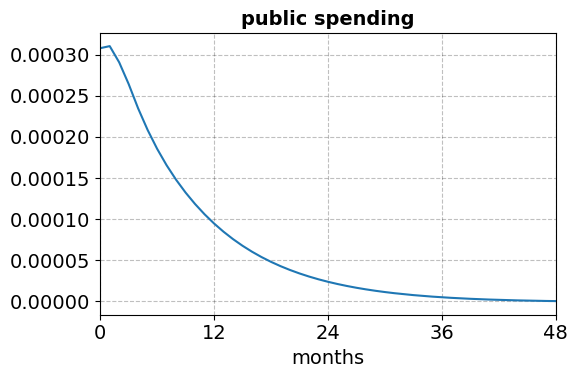

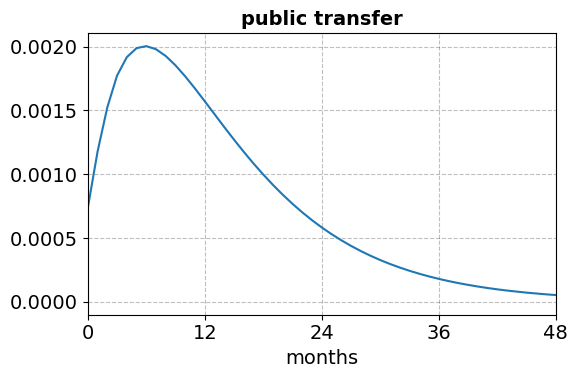

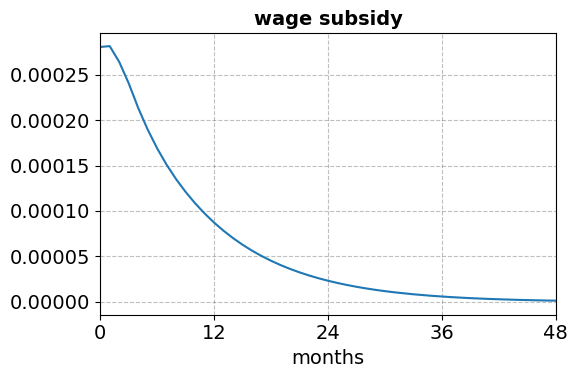

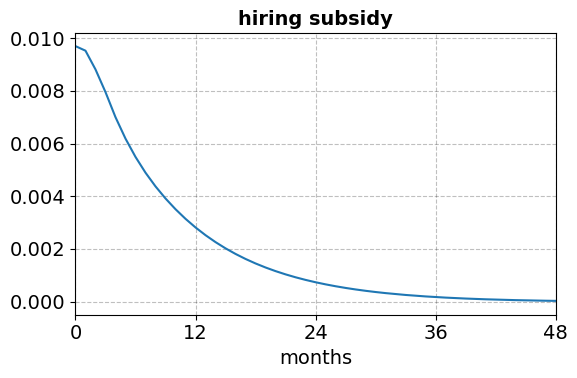

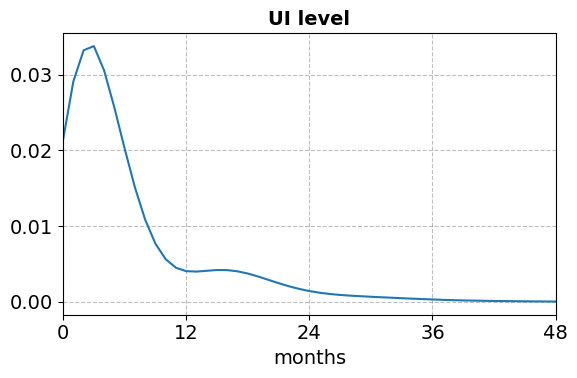

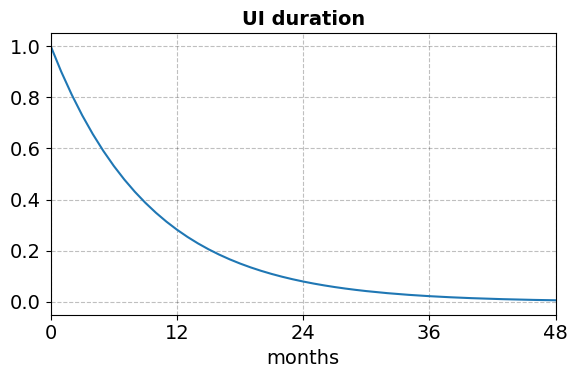

### HtM_debt ###


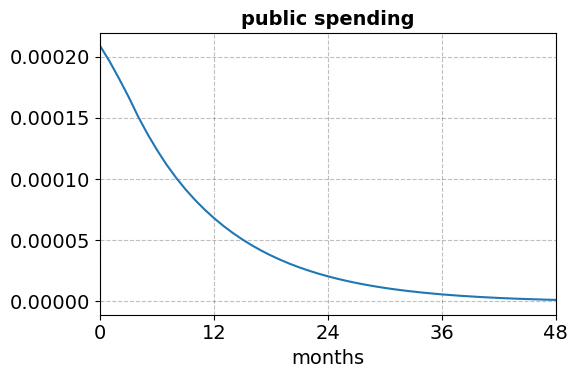

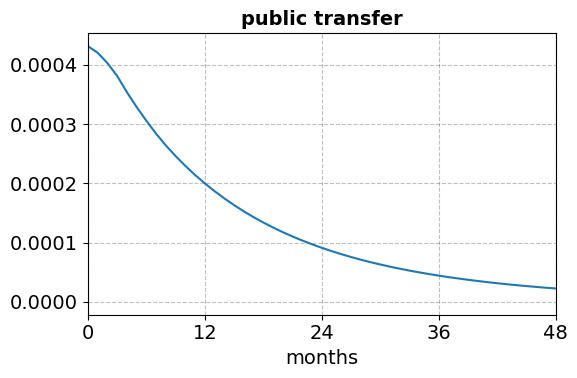

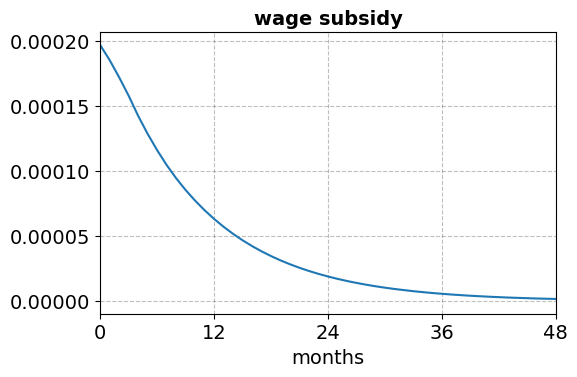

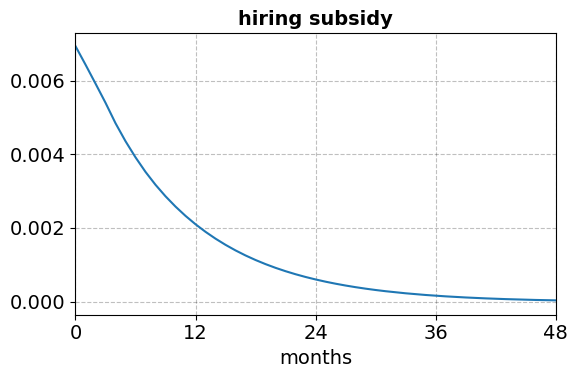

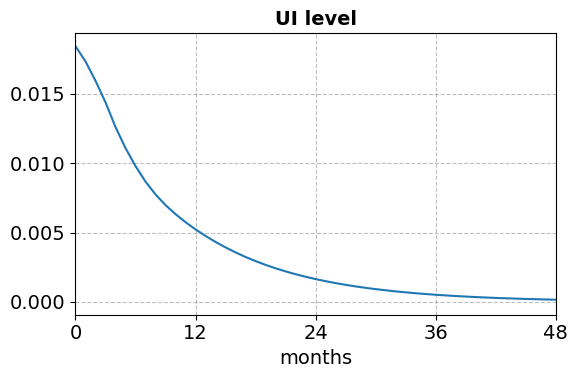

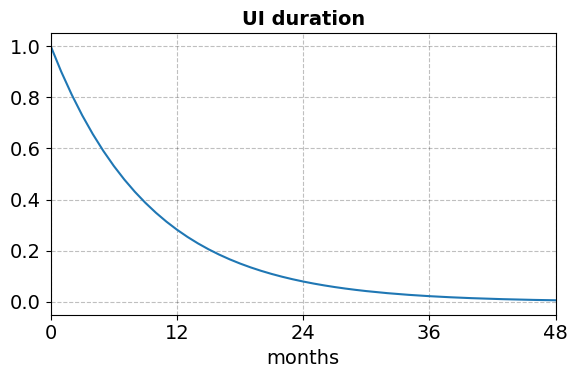

In [15]:
for model_ in models:
    
    print(f'### {model_.name} ###')
    
    for pol,polname,_,_ in pols:
    
        fig,ax = create_fig()
        d = calc(model_,pol)
        ax.plot(scale*d['pol'])
        save_fig(fig,ax,filename=f'pol_{model_.name}_{pol}',title=polname,ylabel='',T_max=48)
        
        plt.show()

### baseline - G ###
### baseline - public_transfer ###
### baseline - wage_subsidy ###
### baseline - hiring_subsidy ###
### baseline - phi_obar ###
### baseline - u_bar ###


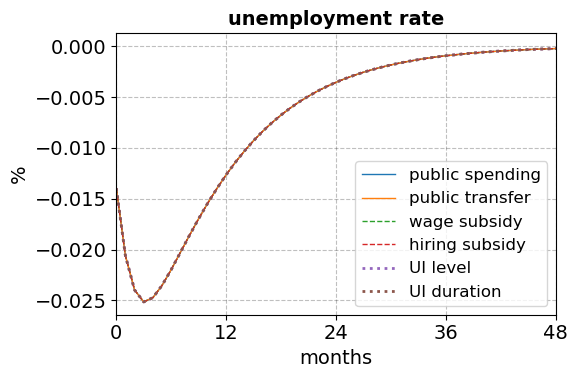

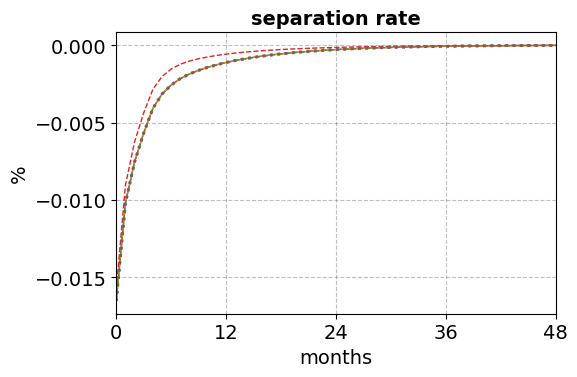

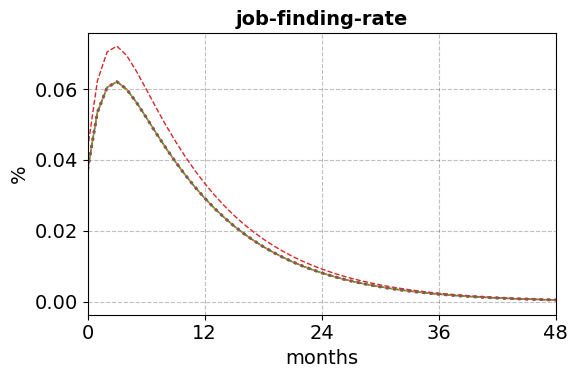

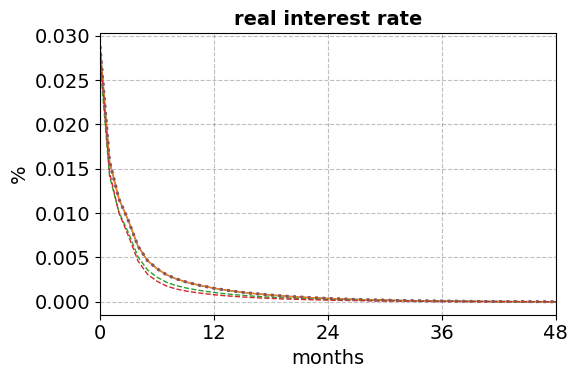

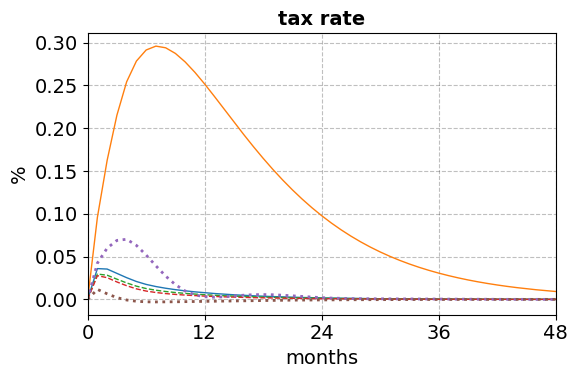

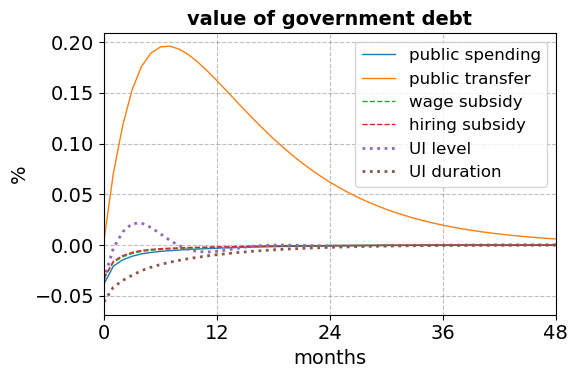

### HtM_debt - G ###
### HtM_debt - public_transfer ###
### HtM_debt - wage_subsidy ###
### HtM_debt - hiring_subsidy ###
### HtM_debt - phi_obar ###
### HtM_debt - u_bar ###


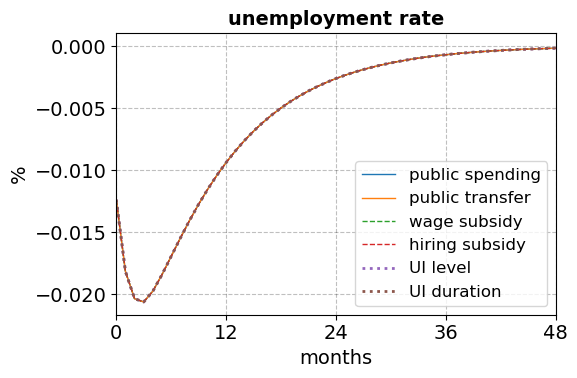

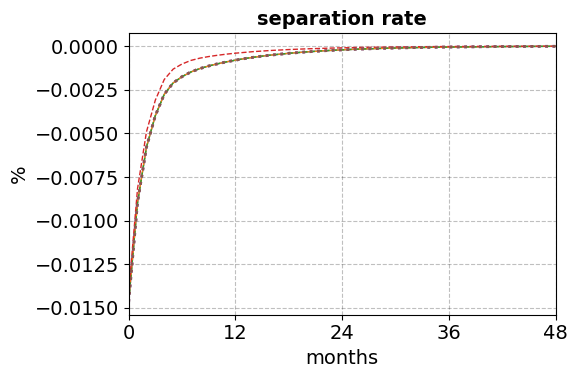

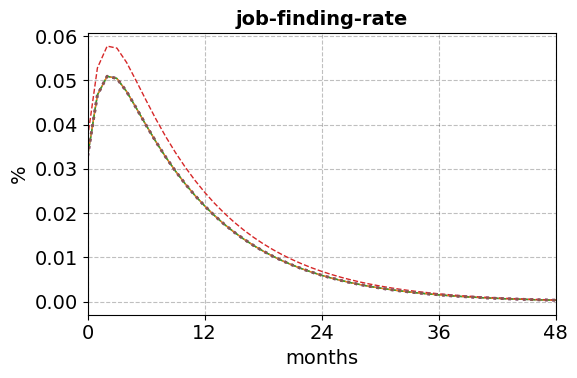

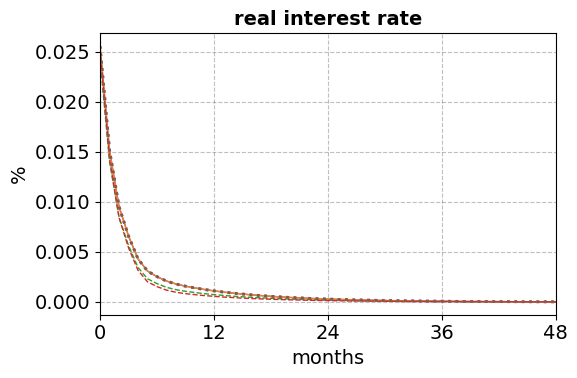

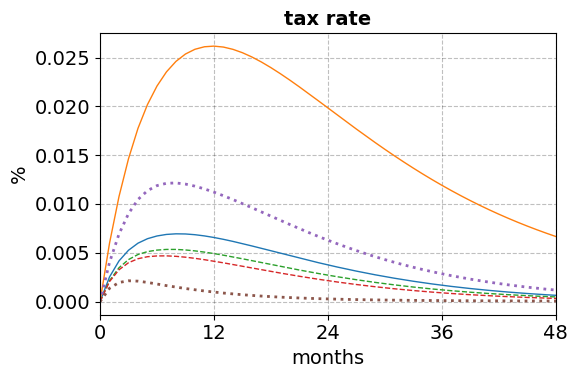

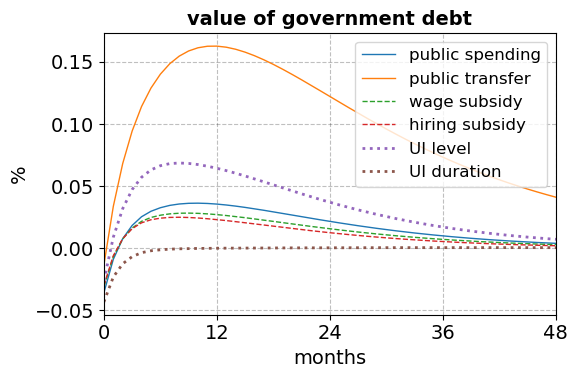

In [16]:
for model_ in models:
    
    figs = {}
    axs = {}

    for varname,_ in varlist:
        figs[varname],axs[varname] = create_fig()

    for pol,polname,ls,lw in pols:

        print(f'### {model_.name} - {pol} ###')

        d = calc(model_,pol)
        for varname,_ in varlist:
            axs[varname].plot(scale*d[varname]*100,label=f'{polname}',ls=ls,lw=lw)

    for varname,vartitle in varlist:    
        save_fig(figs[varname],axs[varname],filename=f'pol_{model_.name}_{varname}',
                 title=f'{vartitle}',ylabel='%',legend=varname in ['u','qB'],T_max=48)
    
    plt.show()